---
# Model S - From Scratch, No Data Augmentation, RMSProp  
- 32 x 32 x 3 Image size.  
- **32 Batch size**.  
- **No data augmentation**.  
- Root Mean Square Propagation **(RMSProp) optimizer**.  
- **0.001 Initial Learning rate**.  
- 3 x 3 Convolutional kernel size.  
- 5 x 5 x 128 Tensor before flatten.  
- **40 Epochs**.  

---
#### Imports and Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)
import matplotlib.pyplot as plt
import pickle
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import callbacks, layers, optimizers, models
from keras import regularizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay ,accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

TensorFlow version: 2.12.0


---
#### Group Datasets

In [2]:
train_dirs = ['../data/train1', '../data/train3', '../data/train4', '../data/train5']
validation_dir = '../data/train2'
test_dir = '../data/test'

- ((2221985 + 2221986) % 5) + 1 = 2  
- **Validation set: train2**.  

---
####  Count Images in Categories

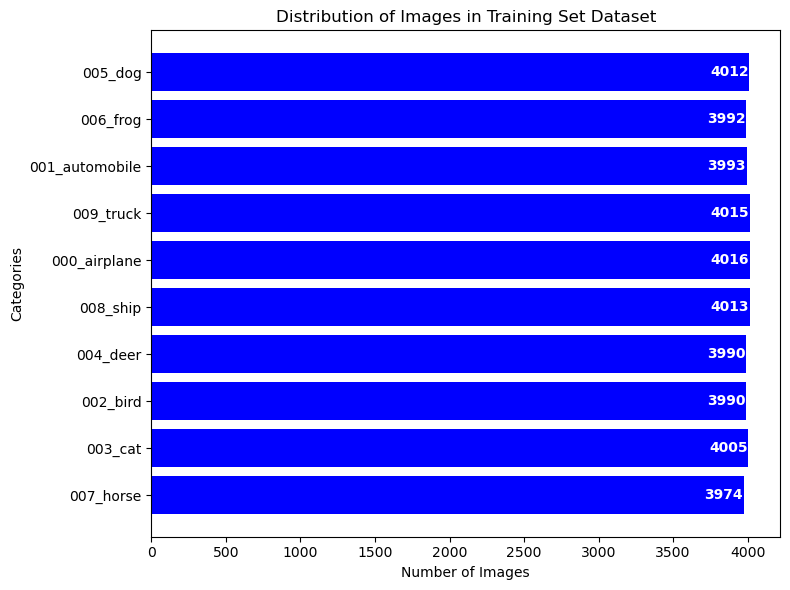

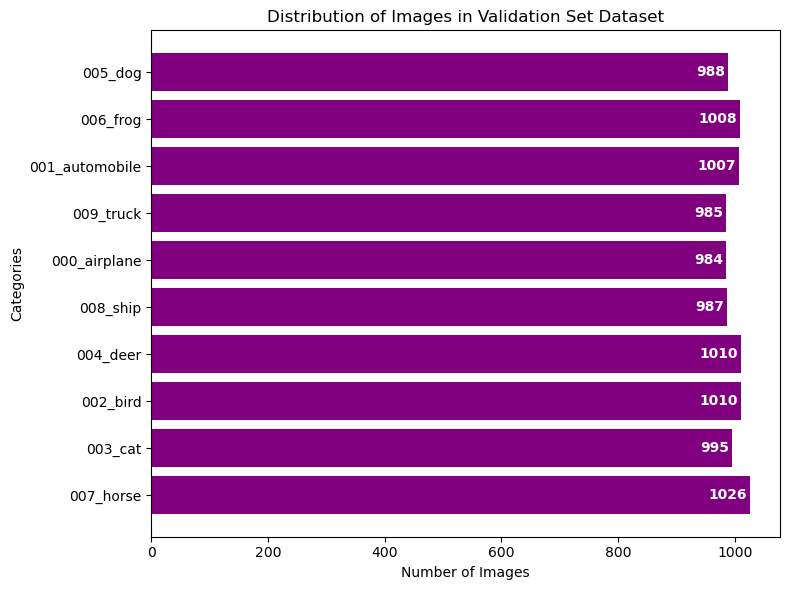

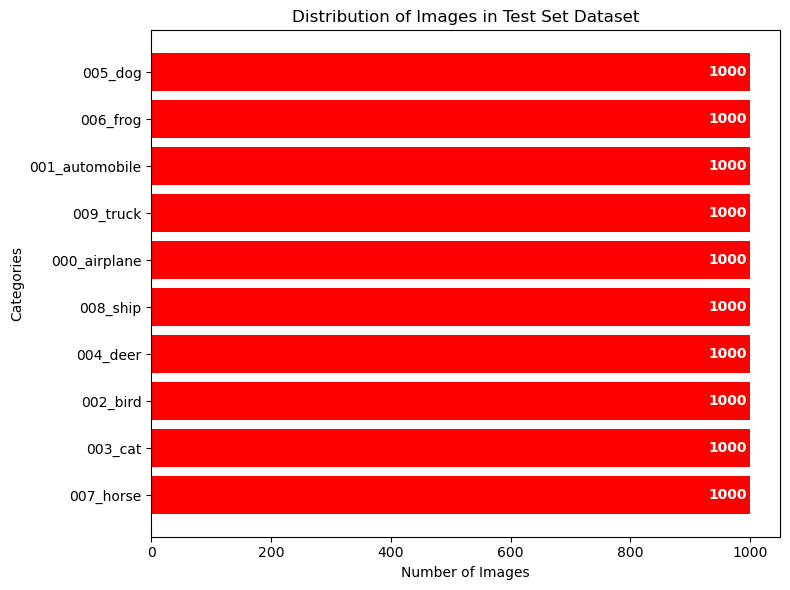

In [3]:
def count_images_in_categories(directory):
    categories = os.listdir(directory)
    category_counts = {}
    for category in categories:
        category_counts[category] = len(os.listdir(os.path.join(directory, category)))
    return category_counts

train_counts_each_dir = [count_images_in_categories(train_dir) for train_dir in train_dirs]
validation_counts = count_images_in_categories(validation_dir)
test_counts = count_images_in_categories(test_dir)
train_counts = {category: sum([count.get(category, 0) for count in train_counts_each_dir]) for category in train_counts_each_dir[0]}

def plot_statistics(dataset_name, category_counts, color):
    categories = list(category_counts.keys())
    counts = list(category_counts.values())
    num_categories = len(categories)
    plt.figure(figsize=(8, 6))
    bars = plt.barh(range(num_categories), counts, color=color, alpha=1)

    for bar, count in zip(bars, counts):
        plt.text(bar.get_width() - 5, bar.get_y() + bar.get_height()/2, str(count), va='center', ha='right', color='white', fontweight='bold')
        
    plt.ylabel('Categories')
    plt.xlabel('Number of Images')
    plt.yticks(range(num_categories), categories)
    plt.title(f'Distribution of Images in {dataset_name} Dataset')
    plt.tight_layout()
    plt.show()

plot_statistics('Training Set', train_counts, 'blue')
plot_statistics('Validation Set', validation_counts, 'purple')
plot_statistics('Test Set', test_counts, 'red')

- We count the images of each category in each folder and plot the distribution.  
- We see that there are **minor deviations** the number of samples of each category in the train dataset and a bit **more in the validation dataset**. 

---
#### Create Datasets

In [4]:
IMG_SIZE = 32
BATCH_SIZE = 32
NUM_CLASSES = len(train_counts)

train_datasets = [image_dataset_from_directory(directory, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE) for directory in train_dirs]

train_dataset = train_datasets[0]
for dataset in train_datasets[1:]:
    train_dataset = train_dataset.concatenate(dataset)

train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = image_dataset_from_directory(validation_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = image_dataset_from_directory(test_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

class_names = train_datasets[0].class_names

Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


- We define the image size of 32 x 32 x 3 and batch size of 32 and create an array with the label's names.  
- We create the train dataset by concatenating them, we **shuffle** the samples before each epoch and **prefetch** them to memory.  
- We do the same for the validation and test dataset except shuffling which is unnecessary.

---
#### Dataset Analysis

In [5]:
for data_batch, labels_batch in train_dataset.take(1):
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)

data batch shape: (32, 32, 32, 3)
labels batch shape: (32,)


- We have batches of 32 images, 32 by 32 pixels with 3 channels (RGB).  
- We also have batches of 32 labels, one for each image.  

---
#### Dataset Visualization

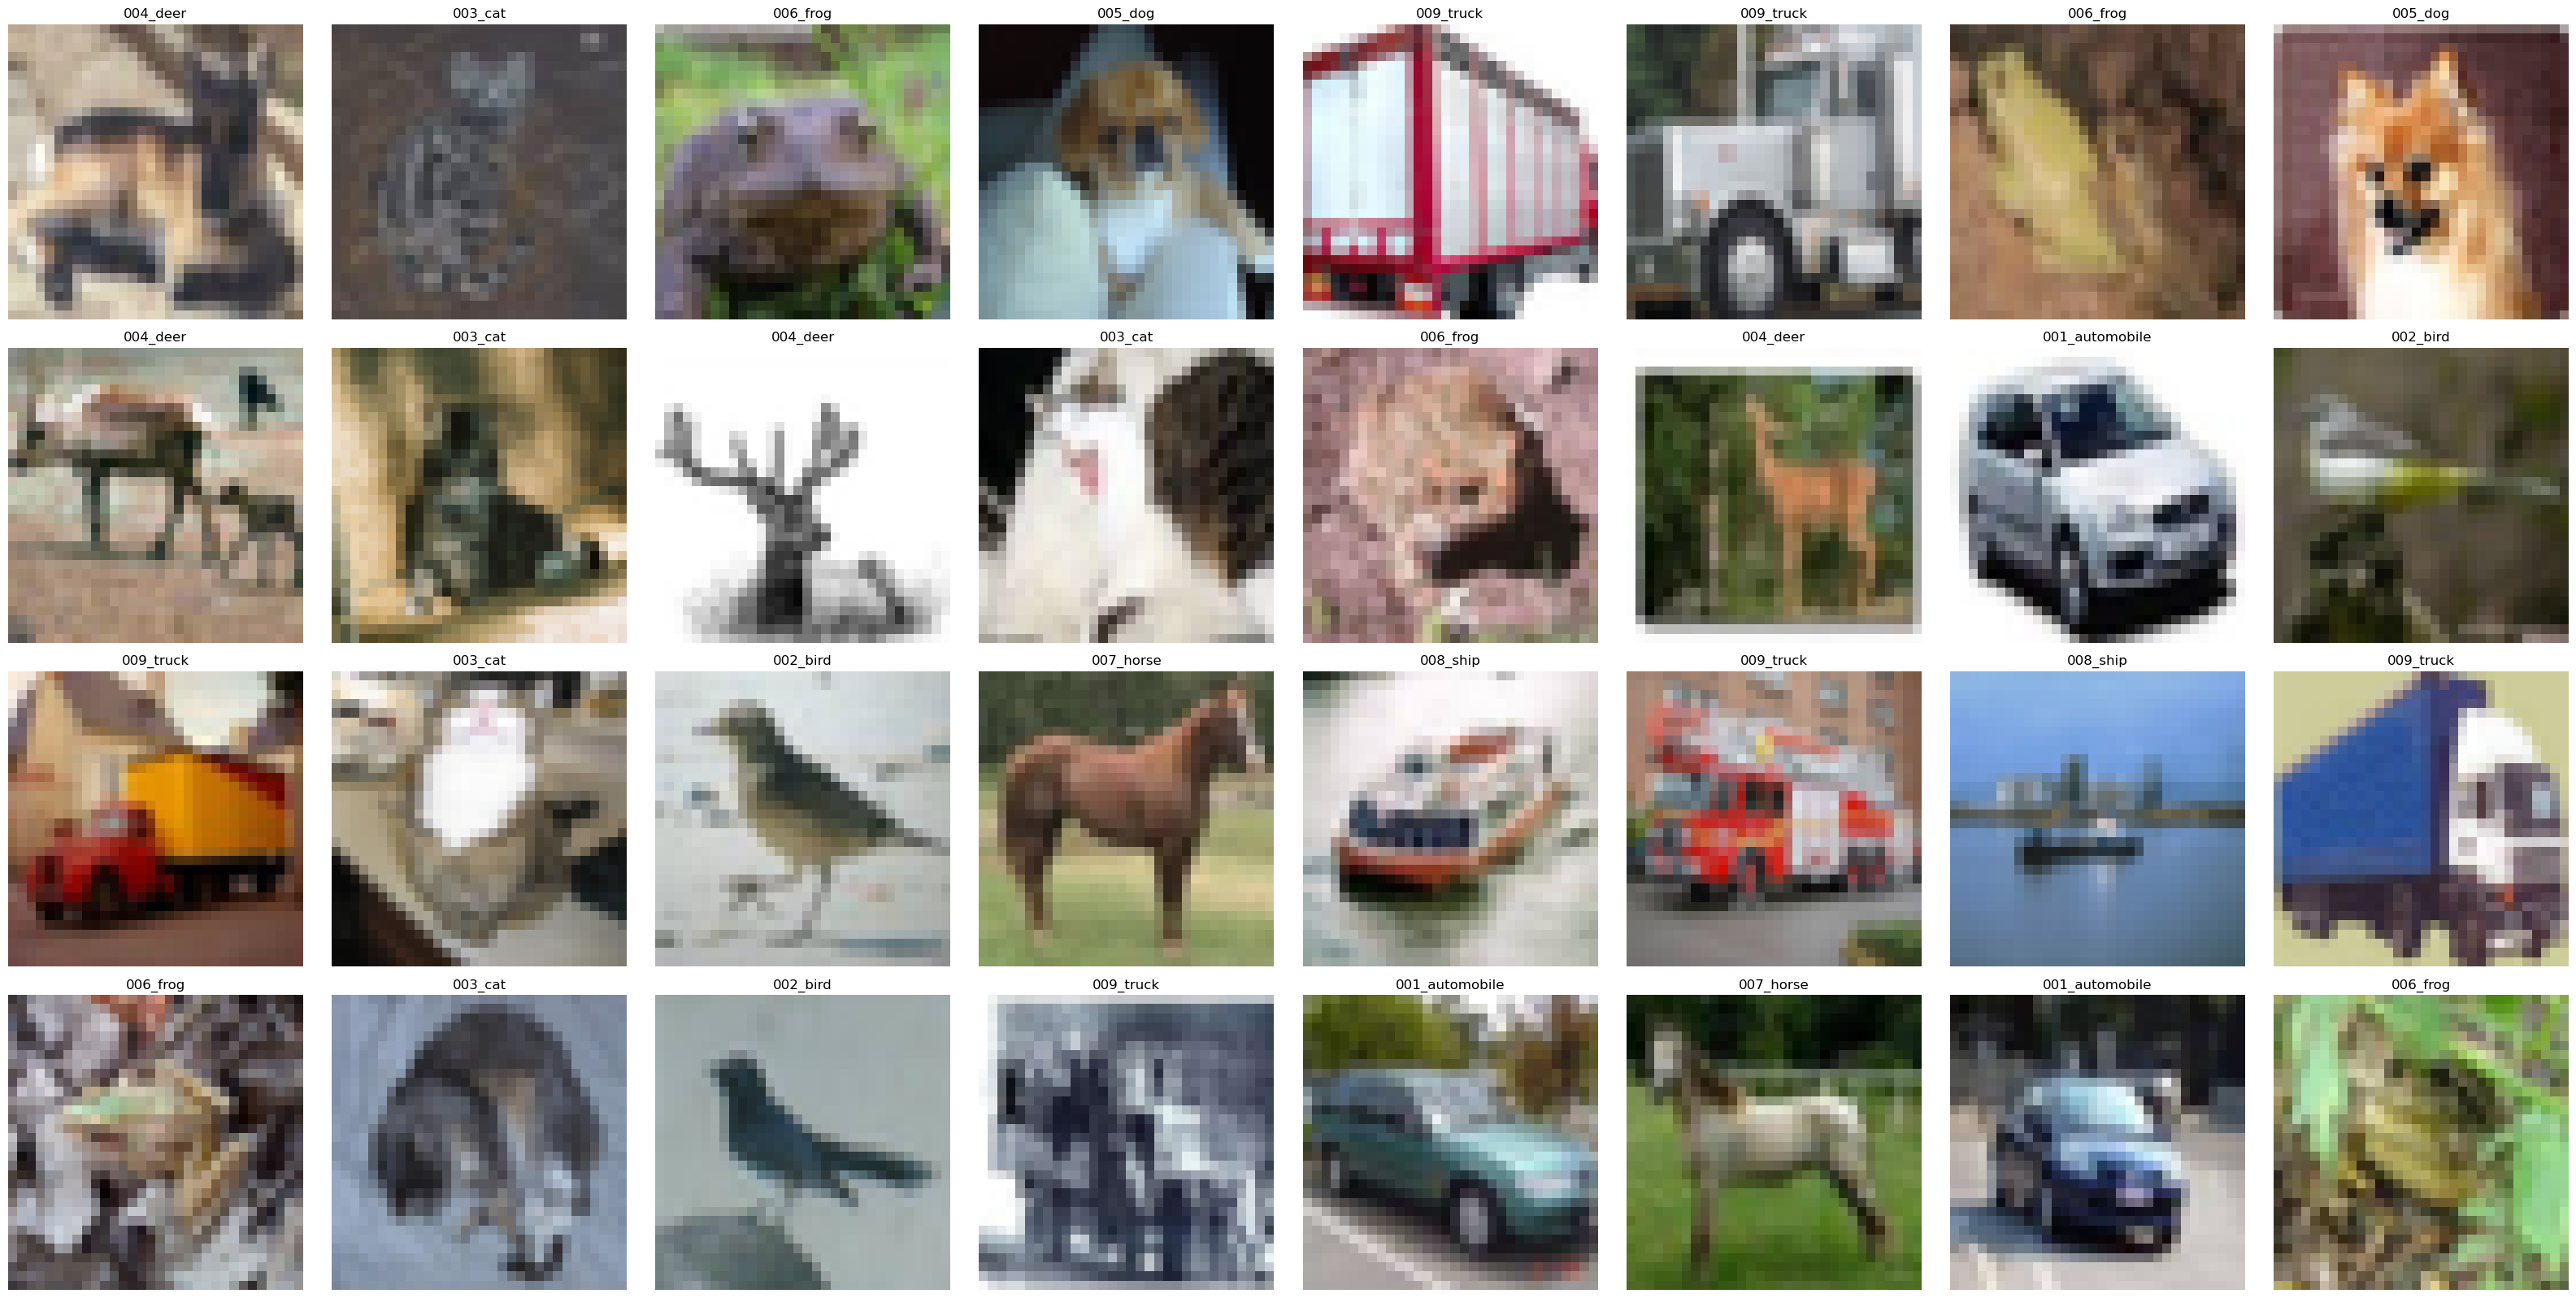

In [6]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(32, 32))
    for i in range(len(images)):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
        plt.tight_layout()
    plt.show()

- We print a random batch of images from the train dataset along with their respective labels.  
- We see that the images are of **different categories** and are of **low resolution**.

---
#### Model Arquitecture

In [7]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, kernel_regularizer=regularizers.L1L2(0.00001, 0.0001), activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=64, kernel_size=3, kernel_regularizer=regularizers.L1L2(0.00001, 0.0001), activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, kernel_regularizer=regularizers.L1L2(0.00001, 0.0001), activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=128, kernel_size=3, kernel_regularizer=regularizers.L1L2(0.00001, 0.0001), activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.L1L2(0.001, 0.01))(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", kernel_regularizer=regularizers.L1L2(0.001, 0.01))(x)
model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                             

- Input size of 32 x 32 x 3 (RGB).  
- No data augmentation.  
- Normalize each pixel value in the [0, 1] interval.  
- 3 x 3 convolutional kernel size.  
- Batch Normalization after each convolutional layer to help stabilize and accelerate learning process.  
- L1 regularization 0.00001 and L2 regularization 0.0001 on the convolutional layers.  
- Two convolutional layers (32 and 64 kernels each respectively).  
- Max pooling with size 2 after the second convolution results in a 14 x 14 x 64 tensor.  
- Two convolutional layers (128 kernels each).  
- Max pooling with size 2 after the fourth convolution results in a 5 x 5 x 128 tensor.  
- Flatten the tensor to a 3200 x 1 tensor.  
- A 512 and 10 dense output layer.  
- L1 regularization 0.001 and L2 regularization 0.01 on the 512 and 10 dense layer.  
- Dropout of 0.5 on the 512 dense layer.  
- ReLU activation function on the convolutional and dense layers.  
- Softmax activation function on the output layer.  
- 10 output neurons, one for each category.  

---
#### Model Compilation

In [8]:
initial_learning_rate = 0.001
optimizer = optimizers.RMSprop(learning_rate=initial_learning_rate)
loss_function = keras.losses.SparseCategoricalCrossentropy()

lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
save_best_model = callbacks.ModelCheckpoint(filepath='../models/model_s_no_data_augm_rmsprop.h5', save_best_only=True, monitor='val_loss', verbose=1)

callbacks = [lr_scheduler, early_stopping, save_best_model]

model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

- RMSProp as the optimizer for this model with an initial learning rate of 0.001.  
- Sparse categorical cross entropy as the loss function.  
- Learning rate scheduler to lower the learning rate by 0.1 on validation loss plateau (patience of 4).  
- Early train stopping based on validation loss improvement (stops when validation loss doesn't improve for 8 straight epochs (patience of 8)).  
- Checkpoints to save the best model between each epoch based on validation loss.  

---
#### Model Training
- Training the model during 40 epochs.  

In [9]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=40,
                    callbacks=callbacks)

Epoch 1/40
1251/1252 [============================>.] - ETA: 0s - loss: 5.3191 - accuracy: 0.5260
Epoch 1: val_loss improved from inf to 2.43643, saving model to ../models/model_s_no_data_augm_rmsprop.h5
1252/1252 [==============================] - 56s 44ms/step - loss: 5.3168 - accuracy: 0.5261 - val_loss: 2.4364 - val_accuracy: 0.6386 - lr: 0.0010
Epoch 2/40
1252/1252 [==============================] - ETA: 0s - loss: 2.3382 - accuracy: 0.6633
Epoch 2: val_loss improved from 2.43643 to 2.36911, saving model to ../models/model_s_no_data_augm_rmsprop.h5
1252/1252 [==============================] - 64s 51ms/step - loss: 2.3382 - accuracy: 0.6633 - val_loss: 2.3691 - val_accuracy: 0.6529 - lr: 0.0010
Epoch 3/40
1251/1252 [============================>.] - ETA: 0s - loss: 2.2272 - accuracy: 0.6994
Epoch 3: val_loss improved from 2.36911 to 2.22486, saving model to ../models/model_s_no_data_augm_rmsprop.h5
1252/1252 [==============================] - 58s 46ms/step - loss: 2.2270 - accuracy

---
#### Save Model History

In [10]:
with open("../history/model_s_no_data_augm_rmsprop.pkl", "wb") as file:
    pickle.dump(history.history, file)

---
#### Model Evaluation

In [11]:
val_loss, val_acc = model.evaluate(validation_dataset)
print('Model Validation Loss: ', val_loss)
print('Model Validation Accuracy: ', val_acc)

313/313 [==============================] - 2s 7ms/step - loss: 0.9465 - accuracy: 0.8358
Model Validation Loss:  0.9465024471282959
Model Validation Accuracy:  0.8357999920845032


---
#### Model Training Visualization

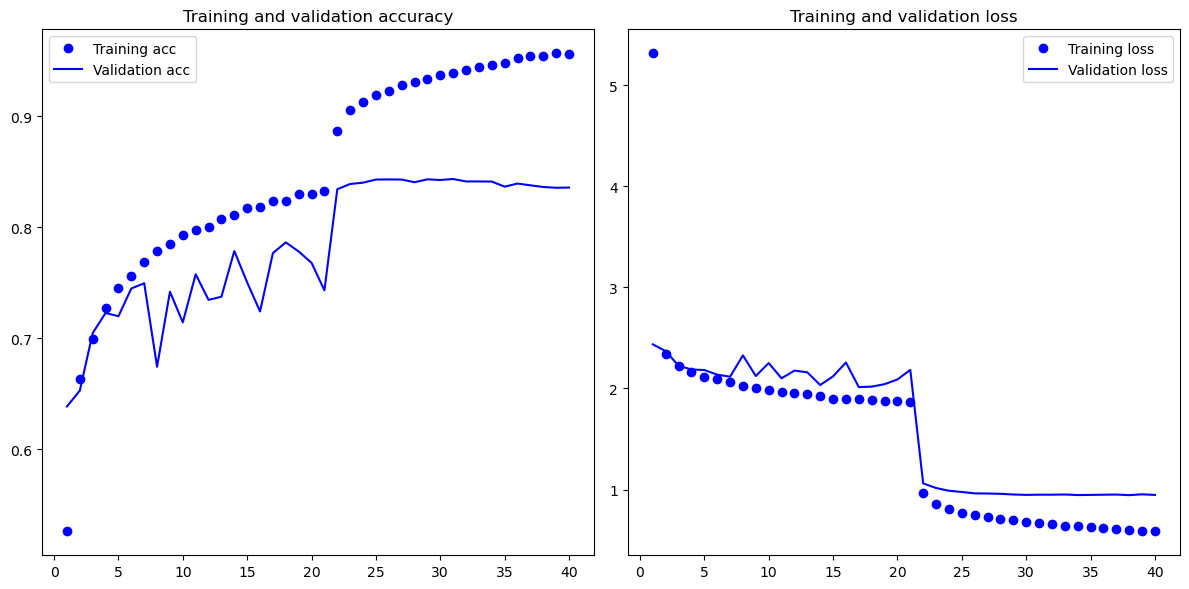

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()
plt.show()

- We see that the model begins overfitting after 22 epochs.  
- The validation accuracy stops improving significantly after the 22th epoch while the training accuracy keeps improving.  
- The validation loss stops improving significantly after the 22th epoch while the training loss keeps improving. 
- However, the best model is saved on the 38th epoch.  

---
#### Model Testing

In [13]:
test_labels = []
test_predictions = []
test_probabilities = []

for images, labels in test_dataset:
    test_labels.extend(labels.numpy())
    predictions = model.predict(images)
    test_predictions.extend(np.argmax(predictions, axis=-1))
    test_probabilities.extend(predictions)

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)
test_probabilities = np.array(test_probabilities)

1/1 [==============================] - 0s 68ms/step


---
#### Confusion Matrix

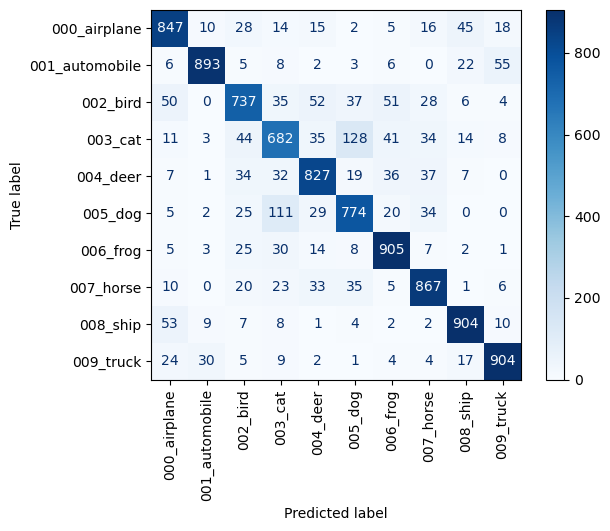

In [14]:
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.show()

- Looking at the confusion matrix, we see that the model has some trouble distinguishing between some categories.  
- The model has a hard time distinguishing between the categories 003_cat and 005_dog.  
- The model also has a hard time distinguishing between some other categories but the error is not as significant.  
- The model has an acceptable performance on the categories 001_automobile, 006_frog, 008_ship and 009_truck.

---
#### ROC Curve Analysis

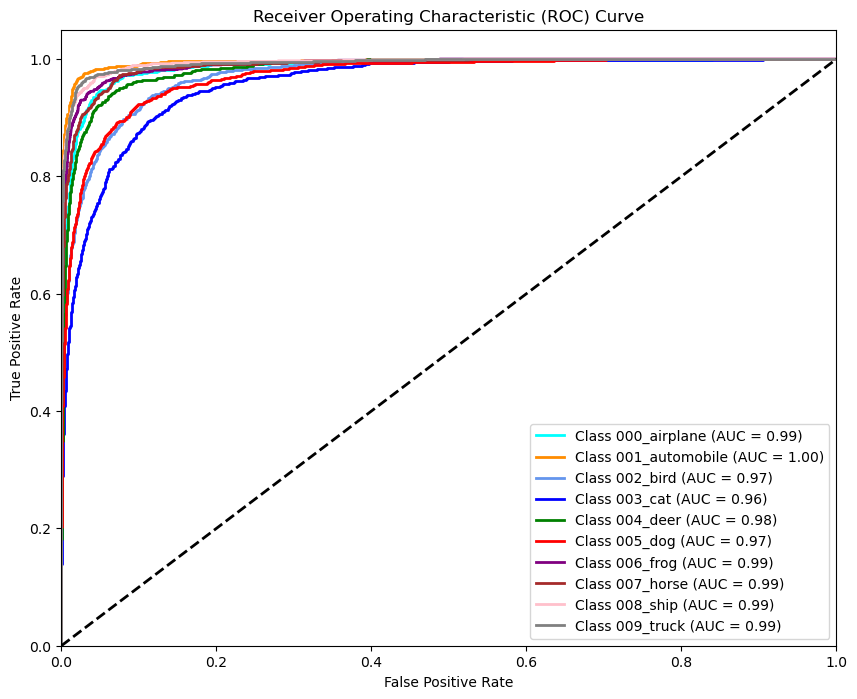

In [15]:
test_labels_bin = label_binarize(test_labels, classes=range(NUM_CLASSES))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'green', 'red', 'purple', 'brown', 'pink', 'grey'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

- We see that the model has a good performance on the ROC curve for most categories.  
- The categories 003_cat, 003_bird, 005_dog and 004_deer have the worst AUC (Area Under Curve) performance.
- A perfect AUC of 1.0 would mean that the model classifies all true positives and true negatives correctly.

---
#### Performance Metrics
- **Accuracy** is the proportion of correctly predicted instances out of the total instances.  
- **Precision** is the ratio of true positive predictions to the total predicted positives. Macro precision calculates this for each class independently and then averages them.  
- **Weighted precision** calculates the precision for each class, then averages them, weighted by the number of true instances for each class.  
- **Recall** is the ratio of true positive predictions to the total actual positives. Macro recall calculates this for each class independently and then averages them.  
- **Weighted recall** calculates the recall for each class, then averages them, weighted by the number of true instances for each class.  
- The **F1-score** is the harmonic mean of precision and recall. Macro F1-score calculates this for each class independently and then averages them.  
- **Weighted F1-score** calculates the F1-score for each class, then averages them, weighted by the number of true instances for each class.

In [16]:
acc = accuracy_score(y_true =  test_labels, y_pred = test_predictions)
print(f'Accuracy : {np.round(acc*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Precision - Macro: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Recall - Macro: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'F1-score - Macro: {np.round(f1*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Precision - Weighted: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Recall - Weighted: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'F1-score - Weighted: {np.round(f1*100,2)}%')

Accuracy : 83.4%
Precision - Macro: 83.35%
Recall - Macro: 83.4%
F1-score - Macro: 83.34%
Precision - Weighted: 83.35%
Recall - Weighted: 83.4%
F1-score - Weighted: 83.34%


- Since the dataset is balanced, the **macro** average is a good metric to evaluate the model.

# Conclusion
- We have trained a model with no data augmentation, using the Sparse Categorical Crossentropy loss function and the RMSProp optimizer.  
- We experimented with various architectures, and this one yielded the best results:  
    - Different learning rates were tested; this rate performed best.  
    - Various batch sizes were explored; this size was optimal.  
    - Multiple optimizers were evaluated; RMSProp was the most effective.
    - Several regularization values were tried; these values worked best.
    - Different dropout rates were assessed; this rate provided the best results.
    - Various epoch counts were tested; 40 epochs were optimal.
    - Different kernel sizes were considered; this size was most effective.
    - Various numbers of kernels were tested; this configuration was best.
    - Different numbers of layers were evaluated; this architecture was optimal.
- For the next notebook, we will retain this architecture to test data augmentation techniques.
- We opted to add Batch Normalization after each convolutional layer.
- We used L1 and L2 regularization on both convolutional and dense layers.
- Dropout was applied to the dense layers.
- The model showed some difficulty distinguishing between certain categories, particularly cats and dogs.
- Overfitting was observed after 22 epochs, but the best model was saved at the 40th epoch.
- The model achieved an accuracy of 83.4% on the test set.
- We evaluated the model using a confusion matrix to analyze its performance on each category.
- We evaluated the model using ROC curves for a deeper performance analysis.
- Performance on the test set was good, with:
    - Macro F1-score: 83.34%
    - Weighted F1-score: 83.34%
    - Macro precision: 83.35%
    - Weighted precision: 83.35%
    - Macro recall: 83.4%
    - Weighted recall: 83.4%

### Future Work
- In the next phase, we will:
    - Implement and test various data augmentation techniques to further improve model generalization.
    - Explore additional regularization methods to address overfitting.
